## Chest X-Ray Image Classification - Dudi

### 1. Imports

In [1]:
import zipfile
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### 2. Data preparation

##### &emsp; A. Extract dataset:

In [2]:
main_path=os.getcwd()
zip_file_path = '{}/archive.zip'.format(main_path)
target_dir = '{}/dataset'.format(main_path)
#zfile = zipfile.ZipFile(zip_file_path)
#zfile.extractall(target_dir)

In [18]:
with zipfile.ZipFile(zip_file_path) as zf:
     for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, target_dir)
        except zipfile.error as e:
            pass

Extracting : 100%|███████████████████████| 17591/17591 [00:19<00:00, 889.77it/s]


##### &emsp; B. Print dataset hierarchy:

In [3]:
def print_dir_hir(path):
    for dirpath, dirnames, filenames in os.walk(path):
        directory_level = dirpath.replace(path, "")
        directory_level = directory_level.count(os.sep)
        indent = " " * 4
        print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

In [4]:
dataset_path=main_path+'/dataset'
print_dir_hir(dataset_path)

dataset/
    chest_xray/
        test/
            PNEUMONIA/
            NORMAL/
        chest_xray/
            test/
                PNEUMONIA/
                NORMAL/
            train/
                PNEUMONIA/
                NORMAL/
            val/
                PNEUMONIA/
                NORMAL/
        __MACOSX/
            chest_xray/
                test/
                    PNEUMONIA/
                    NORMAL/
                train/
                    PNEUMONIA/
                    NORMAL/
                val/
                    PNEUMONIA/
                    NORMAL/
        train/
            PNEUMONIA/
            NORMAL/
                .ipynb_checkpoints/
        val/
            PNEUMONIA/
            NORMAL/


##### &emsp; C. Define dataset paths:

In [5]:
dataset_group_path=dataset_path+'/chest_xray/'
train_path = dataset_group_path+'train'
test_path = dataset_group_path+'test'
valid_path = dataset_group_path+'val'

##### &emsp; D. Define dataset parameters:

In [ ]:
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 48 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

##### &emsp; E. Loading dataset with keras:

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5217 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Explanation for ImageDataGenerator parameters:

rescale —Each digital image is created by a pixel with a value between 0 and 255. 0 in black, 255 in white. So rescale the scales array of the original image pixel values to be between [0,1] which makes the images contribute more equally to the overall loss. Otherwise, higher pixel range image results in greater loss and a lower learning rate should be used, lower pixel range image would require a higher learning rate.

shear_range — The shape of the image is the transformation of the shear. It fixes one axis and stretches the image at a certain angle known as the angle of the shear.
zoom_range — The image is enlarged by a zoom of less than 1.0. The image is more than 1.0 zoomed out of the picture.

horizontal_flip —Some images are flipped horizontally at random

vertical_flip — Some images are flipped vertically at random

roataion_range — Randomly, the image is rotated by some degree in the range 0 to 180.

width_shift_range — Shifts the image horizontally.

height_shift_range — Shifts the image vertically.

brightness_range — brightness of 0.0 corresponds to absolutely no brightness, and 1.0 corresponds to maximum brightness

fill_mode — Fills the missing value of the image to the nearest value or to the wrapped value or to the reflecting value.


##### &emsp; F. Show some examples of data:

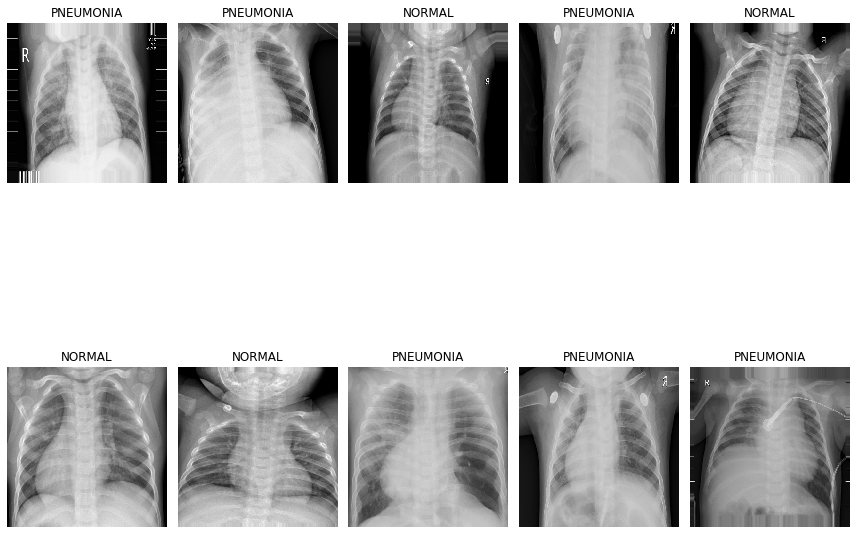

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### 3. Model Creation

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [26]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 60, 60, 32)      

In [13]:
pip install pydot

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install graphviz

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [32]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
#monitor: Quantity to be monitored.
#min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
#min mode, training will stop when the quantity monitored has stopped decreasing.
#patience: Number of epochs with no improvement after which training will be stopped.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
#factor (float) – Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
#patience (int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
callbacks_list = [early, learning_rate_reduction]

In [30]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train.classes), y= train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9437406855439643, 1: 0.6731612903225807}


In [31]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/5
327/327 [==============================] - 361s 1s/step - loss: 0.4162 - accuracy: 0.7761 - val_loss: 0.5370 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/5
327/327 [==============================] - 366s 1s/step - loss: 0.2426 - accuracy: 0.8984 - val_loss: 0.4670 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/5
327/327 [==============================] - 379s 1s/step - loss: 0.2249 - accuracy: 0.9086 - val_loss: 0.5459 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/5
327/327 [==============================] - 356s 1s/step - loss: 0.1910 - accuracy: 0.9224 - val_loss: 0.3451 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/5
327/327 [==============================] - 399s 1s/step - loss: 0.1784 - accuracy: 0.9304 - val_loss: 0.8392 - val_accuracy: 0.7500 - lr: 0.0010


<AxesSubplot:>

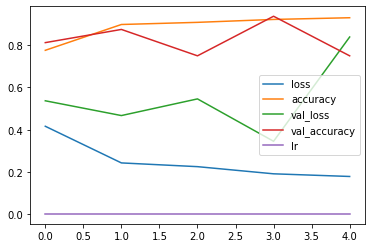

In [34]:
pd.DataFrame(cnn.history.history).plot()

In [35]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 10s 250ms/step - loss: 0.3174 - accuracy: 0.9071
The testing accuracy is : 90.70512652397156 %


In [36]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 11s 269ms/step


In [37]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<AxesSubplot:>

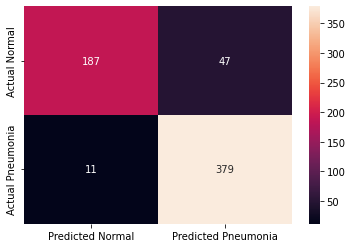

In [39]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [40]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))


              precision    recall  f1-score   support

      NORMAL       0.94      0.80      0.87       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



(624, 500, 500, 1)
(624,)


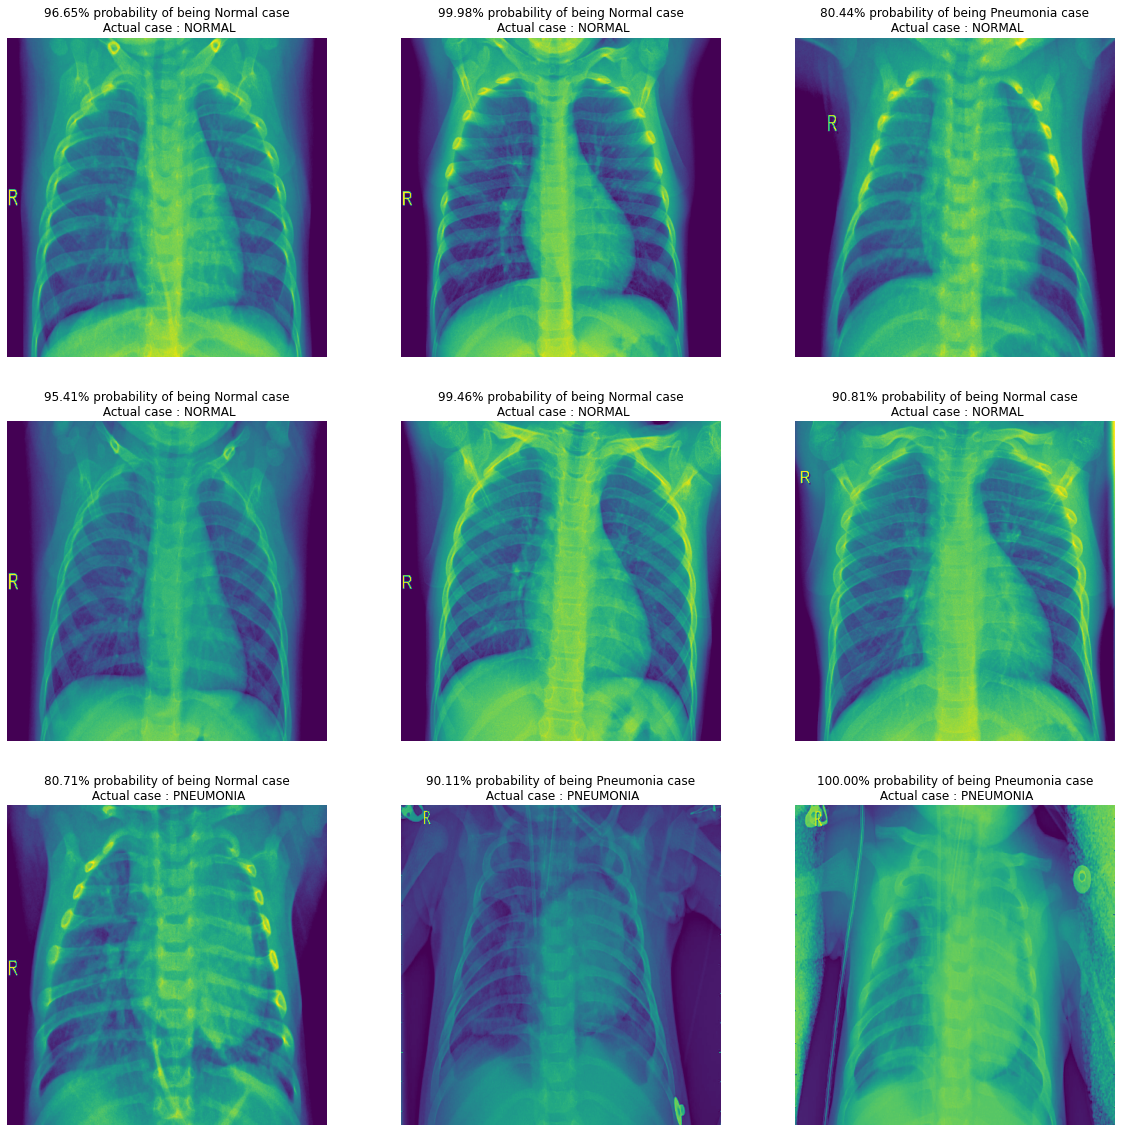

In [46]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
    plt.subplot(3, 3, (i-228)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))  
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
    plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
plt.show()